In [ ]:
#how data are represented at each level (forward, backward, forward with padding on top) needs a little
    #experimentation to determine the best representation
    #also, is encoding at each layer really the best way? or just feeding the raw through?
    
#Outside web ips are going to be a problem/messy/noisy. Start by categorizing all outside ips by <OUTSIDE_IP>
    #instead of the ip address, or another 4 digit symbol to insert into the hex string.
    
#to help the models generalize more, for a given source ip address with probability p (say p = 0.1) 
    #use the token <OTHER_MACHINE>
    
#should we remove random parts of the header, i.e. checksum

#should I take out bias for RNNs?

#for the decoder,does the fork encoding need to happen ?
    #do we simply cat the hContext with the next words?
    
#Should the architecture just be encode, context and then prediction???

#Input data, should it have character and hex pair encoding as well?

In [1]:
%matplotlib inline

import os
os.environ['THEANO_FLAGS'] = 'floatX=float32,device=gpu'#,optimizer=fast_compile'

import cPickle
import sys
import binascii
import multiprocessing as mp
from itertools import chain
from scapy.all import *
#sys.path.append('hed-dlg/')
from collections import OrderedDict

import numpy as np
import random
from scipy.stats import itemfreq
import matplotlib.pyplot as plt
from copy import copy

import blocks
from blocks.bricks import Linear, Softmax, Softplus, NDimensionalSoftmax, BatchNormalizedMLP, \
                                Rectifier, Logistic, Tanh, MLP
from blocks.bricks.recurrent import GatedRecurrent, Fork, LSTM
from blocks.initialization import Constant, IsotropicGaussian, Identity, Uniform
from blocks.bricks.cost import BinaryCrossEntropy, CategoricalCrossEntropy
from blocks.filter import VariableFilter
from blocks.roles import PARAMETER
from blocks.graph import ComputationGraph

import theano
from theano import tensor as T

sys.setrecursionlimit(100000)
###These warnings do not impede progress
#WARNING: Failed to execute tcpdump. Check it is installed and in the PATH
#WARNING: No route found for IPv6 destination :: (no default route?)


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, CuDNN 4007)


# Data

In [2]:
dataPath = '/data/fs4/datasets/pcaps/bigFlows.pcap'
#pcaps = rdpcap(dataPath)
#sessionPrep = pcaps.sessions()

In [3]:
import ast
import json
import subprocess
import sys

def parse_header(line):
    ret_dict = {}
    h = line.split()
    #ret_dict['direction'] = " ".join(h[3:6])

    if h[2] == 'IP6':
        """
        Conditional formatting based on ethernet type.
        IPv4 format: 0.0.0.0.port
        IPv6 format (one of many): 0:0:0:0:0:0.port
        """
        ret_dict['src_port'] = h[3].split('.')[-1]
        ret_dict['src_ip'] = h[3].split('.')[0]

        ret_dict['dest_port'] = h[5].split('.')[-1].split(':')[0]
        ret_dict['dest_ip'] = h[5].split('.')[0]
    else:
        if len(h[3].split('.')) > 4:
            ret_dict['src_port'] = h[3].split('.')[-1]
            ret_dict['src_ip'] = '.'.join(h[3].split('.')[:-1])
        else:
            ret_dict['src_ip'] = h[3]
            ret_dict['src_port'] = ''

        if len(h[5].split('.')) > 4:
            ret_dict['dest_port'] = h[5].split('.')[-1].split(':')[0]
            ret_dict['dest_ip'] = '.'.join(h[5].split('.')[:-1])
        else:
            ret_dict['dest_ip'] = h[5].split(':')[0]
            ret_dict['dest_port'] = ''

    try:
        if ret_dict['src_port'] == '53' or ret_dict['dst_port'] == '53':
            ret_dict['length'] = int(h[-1][1:-1])
        else:
            try:
                ret_dict['length'] = int(line.split(' length ')[1].split(':')[0])
            except:
                ret_dict['length'] = 0
    except:
        try:
            ret_dict['length'] = int(line.split(' length ')[1].split(':')[0])
        except:
            ret_dict['length'] = 0

    return ret_dict

def parse_data(line, length):
    ret_str = ''
    h, d = line.split(':', 1)
    ret_str = d.strip().replace(' ', '')
    if length != 0:
        ret_str = ret_str[:-(2 * length)]
    return ret_str

def process_packet(output):
    # TODO!! throws away the first packet!
    try:
        ret_header = {}
        ret_dict = {}
        ret_data = ''
        for line in output:
            line = line.strip()
            if line.startswith('0x'):
                data = parse_data(line, ret_header['length'])
                ret_data = ret_data + data
            else:
                ret_header = parse_header(line)
                ret_dict.update(ret_header)
                if ret_data != '':
                    ret_dict['data'] = ret_data
                    ret_data = ''
                yield ret_dict
    except:
        pass
    
def read_pcap(path):
    hex_sessions = {}
    proc = subprocess.Popen('tcpdump -nn -tttt -xx -r '+path,
                            shell=True,
                            stdout=subprocess.PIPE)
    for packet in process_packet(proc.stdout):
        a = str(packet)
    
        a = ast.literal_eval(a)
        if 'data' in a:
            key = (a['src_ip']+":"+a['src_port'], a['dest_ip']+":"+a['dest_port'])
            keys = [k for k in hex_sessions if (k[0] == key[0] and k[1] == key[1]) or (k[0] == key[1] and k[1] == key[0])]
            if len(keys) > 0:
                #hex_sessions[keys[0]].append(a['direction']+a['data'])
                hex_sessions[keys[0]].append(a['data'])
            else:
                #hex_sessions[key] = [a['direction']+a['data']]
                hex_sessions[key] = [a['data']]
    return hex_sessions

In [4]:
hexSessions = read_pcap(dataPath)

#get rid of any sessions with less than 80 characters
for ses in hexSessions.keys():
    paclens = []
    for pac in hexSessions[ses]:
        paclens.append(len(pac))
    if np.min(paclens)<80:
        del hexSessions[ses]

In [ ]:
#turns the sessions into a dictionary key = session_number, val = list of packages in hex
minPackets = 2

def hexSessionDictCreator(scapySessions, minPackets = 2):

    hexSessions = OrderedDict()
    i=0
    for k,v in sessionPrep.items(): # v is the session
        
        if len(v) < minPackets:
            pass
        
        else:
            scpcaps = []    
            
            for p in v: #p is the individual packet in the session  
                
                try: #getting rid of payload
                    rawindex = len(p[Raw]) 
                    #payloadLens.append(rawindex)
                    scpcaps.append(binascii.hexlify(str(p.original)[:-rawindex])) #turn it into hex
                
                except: #if no payload
                    scpcaps.append(binascii.hexlify(str(p.original)))
    
            hexSessions['session_' + str(i)] = scpcaps
            i+=1
    #assert that all sessions have len of at least minPackets
    return hexSessions

hexSessionstest = hexSessionDictCreator(sessionPrep, minPackets=minPackets)

In [5]:
#Making the hex dictionary
def hexTokenizer():
    hexstring = '0,	1,	2,	3,	4,	5,	6,	7,	8,	9,	A,	B,	C,	D,	E,	F,	10,	11,	12,	13,	14,	15,	16,	17,	18,	19\
    ,	1A,	1B,	1C,	1D,	1E,	1F,	20,	21,	22,	23,	24,	25,	26,	27,	28,	29,	2A,	2B,	2C,	2D,	2E,	2F,	30,	31,	32,	33,	34,	35\
    ,	36,	37,	38,	39,	3A,	3B,	3C,	3D,	3E,	3F,	40,	41,	42,	43,	44,	45,	46,	47,	48,	49,	4A,	4B,	4C,	4D,	4E,	4F,	50,	51\
    ,	52,	53,	54,	55,	56,	57,	58,	59,	5A,	5B,	5C,	5D,	5E,	5F,	60,	61,	62,	63,	64,	65,	66,	67,	68,	69,	6A,	6B,	6C,	6D\
    ,	6E,	6F,	70,	71,	72,	73,	74,	75,	76,	77,	78,	79,	7A,	7B,	7C,	7D,	7E,	7F,	80,	81,	82,	83,	84,	85,	86,	87,	88,	89\
    ,	8A,	8B,	8C,	8D,	8E,	8F,	90,	91,	92,	93,	94,	95,	96,	97,	98,	99,	9A,	9B,	9C,	9D,	9E,	9F,	A0,	A1,	A2,	A3,	A4,	A5\
    ,	A6,	A7,	A8,	A9,	AA,	AB,	AC,	AD,	AE,	AF,	B0,	B1,	B2,	B3,	B4,	B5,	B6,	B7,	B8,	B9,	BA,	BB,	BC,	BD,	BE,	BF,	C0,	C1\
    ,	C2,	C3,	C4,	C5,	C6,	C7,	C8,	C9,	CA,	CB,	CC,	CD,	CE,	CF,	D0,	D1,	D2,	D3,	D4,	D5,	D6,	D7,	D8,	D9,	DA,	DB,	DC,	DD\
    ,	DE,	DF,	E0,	E1,	E2,	E3,	E4,	E5,	E6,	E7,	E8,	E9,	EA,	EB,	EC,	ED,	EE,	EF,	F0,	F1,	F2,	F3,	F4,	F5,	F6,	F7,	F8,	F9\
    ,	FA,	FB,	FC,	FD,	FE,	FF'.replace('\t', '')

    hexList = [x.strip() for x in hexstring.lower().split(',')]
    hexList.append('<EOP>') #End Of Packet token
    #EOS token??????
    hexDict = {}

    for key, val in enumerate(hexList):
        if len(val) == 1:
            val = '0'+val
        hexDict[val] = key  #dictionary k=hex, v=int  
    
    return hexDict

In [6]:
hexDict = hexTokenizer()

# Dictionary of IP communications

In [7]:
def srcIpDict(hexSessionDict):
    ''' 
    input: dictionary of key = sessions, value = list of HEX HEADERS of packets in session
    output: dictionary of key = source IP, value/subkey = dictionary of destination IPs, 
                                           subvalue = [[sport], [dport], [plen], [protocol]]
    
    '''
    
    srcIpDict = OrderedDict()   
    uniqIPs = [] #some ips are dest only. this will collect all ips, not just srcIpDict.keys()
    
    for session in hexSessionDict.keys():
        
        for rawpacket in hexSessionDict[session]:
            packet = copy(rawpacket)
            
            dstIpSubDict = {}

            srcip = packet[52:60]
            dstip = packet[60:68]
            sport = packet[68:72]
            dport = packet[72:76]
            plen = packet[32:36]
            protocol = packet[46:48]
            
            uniqIPs = list(set(uniqIPs) | set([dstip, srcip]))

            if srcip not in srcIpDict:
                dstIpSubDict[dstip] = [[sport], [dport], [plen], [protocol]]
                srcIpDict[srcip] = dstIpSubDict

            if dstip not in srcIpDict[srcip]:    
                srcIpDict[srcip][dstip] = [[sport], [dport], [plen], [protocol]]
            else:
                srcIpDict[srcip][dstip][0].append(sport)
                srcIpDict[srcip][dstip][1].append(dport)
                srcIpDict[srcip][dstip][2].append(plen)
                srcIpDict[srcip][dstip][3].append(protocol)

    return srcIpDict, uniqIPs

In [8]:
def dictUniquerizer(dictOdictsOlistOlists):
    '''
    input: dictionary of dictionaries that have a list of lists 
           ex. srcIpDict[srcip][dstip] = [[sport], [dport], [plen], [protocol]]
    output: dictionary of dictionaries with list of lists with unique items in the final sublist
    
    WARNING: will overwrite your input dictionary. Make a copy if you want to preserve dictOdictsOlistOlists.
    '''
    #dictCopy
    for key in dictOdictsOlistOlists.keys():
        for subkey in dictOdictsOlistOlists[key].keys():
            for sublist in xrange(len(dictOdictsOlistOlists[key][subkey])):
                dictOdictsOlistOlists[key][subkey][sublist] = list(set(dictOdictsOlistOlists[key][subkey][sublist]))
    
    return dictOdictsOlistOlists

In [9]:
#TODO: parallelize
#comsDicttest, uniqIPstest = srcIpDict(hexSessionstest)
comsDict, uniqIPs = srcIpDict(hexSessions)

comsDict = dictUniquerizer(comsDict)
#comsDicttest = dictUniquerizer(comsDicttest)

# Adversarial Functions

### Directionality adversary

In [10]:
def ipDirSwitcher(hexSessionList):
    '''
    input is a list of packets from ONE session
    '''
    
    ipdirsession = []
        
    for p in hexSessionList:
        sourceIP = p[52:60]
        destIP = p[60:68]

        ipdirsession.append(p[:52]+destIP+sourceIP+p[68:])

    return ipdirsession

In [11]:
def portDirSwitcher(hexSessionList):
    '''
    input is a list of packets from ONE session
    '''
    
    portdirsession = []
    
    for p in hexSessionList:
        sport = p[68:72]
        dport = p[72:76]

        portdirsession.append(p[:68]+dport+sport+p[76:])

    return portdirsession

### Leave one swap one

In [12]:
def dstIpSwapOut(hexSessionList, dictOcoms, listOuniqIPs):
    #srcIpDict[srcip][dstip] = [[sport], [dport], [plen], [protocol]]
    
    swapSession = []
    srcip = hexSessionList[0][52:60] #assumes first packet contains true initial direction
    dstip = hexSessionList[0][60:68]
    normDstIps = dictOcoms[srcip].keys()+[srcip] #get list of dstIPs that srcIP talks to
    abbynormIps = copy(listOuniqIPs)
    
    for normIp in normDstIps:
        abbynormIps.remove(normIp) #remove itself and know dstIPs from list of consideration.
    
    abbynormDestIp = random.sample(abbynormIps, 1)[0] #get random ip that srcip doesn't talk to

    for rawpacket in hexSessionList:
        packet = copy(rawpacket)
        
        if packet[60:68] == dstip:
            packet = packet[:60] + abbynormDestIp + packet[68:] #
        elif packet[61:69] == srcip:
            packet = packet[:52] + abbynormDestIp + packet[60:] #in case direction switches for packet in session
            
        swapSession.append(packet)

    return swapSession
    

In [ ]:
def dstPortSwapOneOut(hexSessionList):
    #THINK THROUGH
    
    
    
    
    

In [13]:
def oneHot(index, granular = 'hex'):
    if granular == 'hex':
        vecLen = 257
    else:
        vecLen = 17
    
    zeroVec = np.zeros(vecLen)
    zeroVec[index] = 1.0
    
    return zeroVec
 

In [87]:
maxPackets = 3
packetTimeSteps = 80

def oneSessionEncoder(sessionPackets, hexDict, maxPackets = 2, packetTimeSteps = 100,
                       packetReverse = False, charLevel = False, padOldTimeSteps = True):    
            
    sessionCollect = []
    packetCollect = []
    
    if charLevel:
        vecLen = 17
    else:
        vecLen = 257
    
    if len(sessionPackets) > maxPackets: #crop the number of sessions to maxPackets
        sessionList = copy(sessionPackets[:maxPackets])
    else:
        sessionList = copy(sessionPackets)

    for rawpacket in sessionList:
        packet = copy(rawpacket)
        #packet = packet[32:36]+packet[44:46]+packet[46:48]+packet[52:60]+packet[60:68]+\
        #         packet[68:70]+packet[70:72]+packet[72:74]
        packet = [hexDict[packet[i:i+2]] for i in xrange(0,len(packet)-2+1,2)]
        
        #print np.asarray(packet)
            
        if len(packet) >= packetTimeSteps: #crop packet to length packetTimeSteps
            packet = packet[:packetTimeSteps]
            packet = packet+[256] #add <EOP> end of packet token
        else:
            packet = packet+[256] #add <EOP> end of packet token
        
        packetCollect.append(packet)
        
        pacMat = np.array([oneHot(x) for x in packet]) #one hot encoding of packet into a matrix
        pacMatLen = len(pacMat)
        
        #padding packet
        if packetReverse:
            pacMat = pacMat[::-1]

        if pacMatLen < packetTimeSteps:
            #pad by stacking zeros on top of data so that earlier timesteps do not have information
            #padding the packet such that zeros are after the actual info for better translation
            if padOldTimeSteps:
                pacMat = np.vstack( ( np.zeros((packetTimeSteps-pacMatLen,vecLen)), pacMat) ) 
            else:
                pacMat = np.vstack( (pacMat, np.zeros((packetTimeSteps-pacMatLen,vecLen))) ) 

        if pacMatLen > packetTimeSteps:
            pacMat = pacMat[:packetTimeSteps, :]

        sessionCollect.append(pacMat)

    #padding session
    sessionCollect = np.asarray(sessionCollect, dtype=theano.config.floatX)
    numPacketsInSession = sessionCollect.shape[0]
    if numPacketsInSession < maxPackets:
        #pad sessions to fit the 
        sessionCollect = np.vstack( (sessionCollect,np.zeros((maxPackets-numPacketsInSession, 
                                                             packetTimeSteps, vecLen))) )
    
    return sessionCollect, packetCollect

# Learning functions

In [15]:
def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

def dropout(X, p=0.):
    if p != 0:
        retain_prob = 1 - p
        X = X / retain_prob * srng.binomial(X.shape, p=retain_prob, dtype=theano.config.floatX)
    return X

# Gradient clipping
def clip_norm(g, c, n): 
    '''n is the norm, c is the threashold, and g is the gradient'''
    
    if c > 0: 
        g = T.switch(T.ge(n, c), g*c/n, g) 
    return g

def clip_norms(gs, c):
    norm = T.sqrt(sum([T.sum(g**2) for g in gs]))
    return [clip_norm(g, c, norm) for g in gs]

# Regularizers
def max_norm(p, maxnorm = 0.):
    if maxnorm > 0:
        norms = T.sqrt(T.sum(T.sqr(p), axis=0))
        desired = T.clip(norms, 0, maxnorm)
        p = p * (desired/ (1e-7 + norms))
    return p

def gradient_regularize(p, g, l1 = 0., l2 = 0.):
    g += p * l2
    g += T.sgn(p) * l1
    return g

def weight_regularize(p, maxnorm = 0.):
    p = max_norm(p, maxnorm)
    return p

def Adam(params, cost, lr=0.0002, b1=0.1, b2=0.001, e=1e-8, l1 = 0., l2 = 0., maxnorm = 0., c = 8):
    
    updates = []
    grads = T.grad(cost, params)
    grads = clip_norms(grads, c)
    
    i = theano.shared(floatX(0.))
    i_t = i + 1.
    fix1 = 1. - b1**(i_t)
    fix2 = 1. - b2**(i_t)
    lr_t = lr * (T.sqrt(fix2) / fix1)
    
    for p, g in zip(params, grads):
        m = theano.shared(p.get_value() * 0.)
        v = theano.shared(p.get_value() * 0.)
        m_t = (b1 * g) + ((1. - b1) * m)
        v_t = (b2 * T.sqr(g)) + ((1. - b2) * v)
        g_t = m_t / (T.sqrt(v_t) + e)
        g_t = gradient_regularize(p, g_t, l1=l1, l2=l2)
        p_t = p - (lr_t * g_t)
        p_t = weight_regularize(p_t, maxnorm=maxnorm)
        
        updates.append((m, m_t))
        updates.append((v, v_t))
        updates.append((p, p_t))
    
    updates.append((i, i_t))
    #if iteration%100 == 0:
    #    updates.append((lr, lr*0.93))
    #else:
    #    updates.append((lr, lr))
    
    return updates

def RMSprop(cost, params, lr = 0.001, l1 = 0., l2 = 0., maxnorm = 0., rho=0.9, epsilon=1e-6, c = 8):
    
    grads = T.grad(cost, params)
    grads = clip_norms(grads, c)
    updates = []
    
    for p, g in zip(params, grads):
        g = gradient_regularize(p, g, l1 = l1, l2 = l2)
        acc = theano.shared(p.get_value() * 0.)
        acc_new = rho * acc + (1 - rho) * g ** 2
        updates.append((acc, acc_new))
        
        updated_p = p - lr * (g / T.sqrt(acc_new + epsilon))
        updated_p = weight_regularize(updated_p, maxnorm = maxnorm)
        updates.append((p, updated_p))
    return updates

In [ ]:
#makes output by shifting inputs down in time one step and then copying the last time step to the end.
#def targetModifier(targetArray):
#    newTarget = np.vstack((targetArray[1:, :], targetArray[-1,:]))
#    return newTarget

#def targetMaker(listOinputs):
    #TODO: do this with arrays
#    outputs = []
#    for inp in listOinputs:
#        outputs.append(targetModifier(inp))
#    outputs = np.asarray(outputs)
#    
#    return outputs

# Unsupervised feature extractor

### Initialization for both the unsupervised net and the classifier

In [112]:
X = T.tensor4('inputs')
Y = T.matrix('targets')

wtstd = 0.1
dimIn = 257 #hex has 256 characters + the <EOP> character
dim = 50 #dimension reduction size
rnnType = 'gru' #gru or lstm
bidirectional = False
linewt_init = IsotropicGaussian(wtstd)
line_bias = Constant(1.0)
rnnwt_init = IsotropicGaussian(wtstd)
rnnbias_init = Constant(0.0)
packetReverse = False

###ENCODER
if rnnType == 'gru':
    rnn = GatedRecurrent(dim=dim, weights_init = rnnwt_init, biases_init = rnnbias_init, name = 'gru')
    dimMultiplier = 2
else:
    rnn = LSTM(dim=dim, weights_init = rnnwt_init, biases_init = rnnbias_init, name = 'lstm')
    dimMultiplier = 4

fork = Fork(output_names=['linear', 'gates'],
            name='fork', input_dim=dimIn, output_dims=[dim, dim * dimMultiplier], 
            weights_init = linewt_init, biases_init = line_bias)


###CONTEXT
if rnnType == 'gru':
    rnnContext = GatedRecurrent(dim=dim, weights_init = rnnwt_init, 
                                biases_init = rnnbias_init, name = 'gruContext')
else:
    rnnContext = LSTM(dim=dim, weights_init = rnnwt_init, biases_init = rnnbias_init, 
                      name = 'lstmContext')

forkContext = Fork(output_names=['linearContext', 'gatesContext'],
            name='forkContext', input_dim=dim, output_dims=[dim, dim * dimMultiplier], 
            weights_init = linewt_init, biases_init = line_bias)

if bidirectional:
    dimDec = dim*2
    
    if rnnType == 'gru':
        rnnContextRev = GatedRecurrent(dim=dim, weights_init = rnnwt_init, 
                                       biases_init = rnnbias_init, name = 'gruContextRev')
        
    else:
        rnnContextRev = LSTM(dim=dim, weights_init = rnnwt_init, biases_init = rnnbias_init,
                             name = 'lstmContextRev')
    
    rnnContextRev.initialize()

else:
    dimDec = dim


###DECODER
if rnnType == 'gru':
    rnnDec = GatedRecurrent(dim=dimIn, weights_init = rnnwt_init, 
                            biases_init = rnnbias_init, name = 'gruDecoder')
else:
    rnnDec = LSTM(dim=dimIn, weights_init = rnnwt_init, biases_init = rnnbias_init, name = 'lstmDecoder')


forkDec = Fork(output_names=['linear', 'gates'],
            name='forkDec', input_dim=dimDec, output_dims=[dim, dim*dimMultiplier], 
            weights_init = linewt_init, biases_init = line_bias)

forkFinal = Fork(output_names=['linear', 'gates'],
            name='forkFinal', input_dim=dim, output_dims=[dimIn, dimIn*dimMultiplier], 
            weights_init = linewt_init, biases_init = line_bias)

#initialize the weights in all the functions
fork.initialize()
rnn.initialize()

forkContext.initialize()
rnnContext.initialize()
forkDec.initialize()

forkFinal.initialize()
rnnDec.initialize()

### Unsupervised graph

In [113]:
#This section can be skipped if you want to go directly to the classifier

learning_rate = theano.shared(np.array(0.0001, dtype=theano.config.floatX))
learning_decay = np.array(0.9, dtype=theano.config.floatX)
batch_size = 20
maxPackets = 3

def onestepEnc(X):

    data1, data2 = fork.apply(X)
    
    if rnnType == 'gru':
        hEnc = rnn.apply(data1, data2) 
    else:
        hEnc, _ = rnn.apply(data2)
    
    return hEnc, data1

[hEnc, data1], _ = theano.scan(onestepEnc, X)
hEncReshape = T.reshape(hEnc[:,-1], (batch_size, maxPackets, 1, dim))#take last representation of packet

def onestepContext(hEncReshape):
    
    data3, data4 = forkContext.apply(hEncReshape)
    
    if rnnType == 'gru':
        hContext = rnnContext.apply(data3, data4)
    else:
        hinitContext, _ = rnnContext.apply(data4)
        hContext = hinitContext 
    
    return hContext

hContext, _ = theano.scan(onestepContext, hEncReshape) #shape = (batch_size,maxPackets,1,dim)
#hContextReshape = T.concatenate((hContext[:,:-1], T.reshape(data1, (20, 3, 100, 100))[:,1:,:-1]), axis = 2)

data5, _ = forkDec.apply(hContext) #this fork makes data5 same dim as data1 (the orig word embedding)

#decoding data needs to be one timestep (next packet in session) ahead, thus data1 we ignore the first packet
#and the last hidden state of the context RNN.
#THINK about L2 pooling before cat
#THINK should we concatenate with X instead of data5
#if packetReverse:
#    data1 = data1[:,::-1]
#do we need data5??

data7 = T.concatenate((data5[:,:-1], 
                       T.reshape(data1, (batch_size, maxPackets, packetTimeSteps, dim))[:,1:,:-1]), 
                      axis = 2)
                      
                      #data1 is the original embedding of X, data5 is transformed context output
                      #get rid of first packet in data 5
                      #get rid of last context vector

#predicts all but the first packet, i.e. session[1:]
#output.shape = (20, 2, 100, 257), (minibatch, 
def onestepDec(data7):
    
    data8, data9 = forkFinal.apply(data7) #forkFinal transforms back to original dimIn
    
    if rnnType == 'gru':
        hDec = rnnDec.apply(data8, data9) 
    else:
        hDec, _ = rnnDec.apply(data9)
        #hDec = hinit #hDec shape = (batch_size*(maxPackets-1), packetTimeSteps, 257)
    
    return hDec


hDec, _ = theano.scan(onestepDec, data7)

hDecReshape = T.reshape(hDec, (batch_size*(maxPackets-1), packetTimeSteps, dimIn))


softmax = NDimensionalSoftmax()
softout = softmax.apply(hDecReshape, extra_ndim = 1)
predX = T.reshape(T.reshape(X,(batch_size, maxPackets, packetTimeSteps, dimIn))[:,1:,:,:], 
                  (batch_size*(maxPackets-1), packetTimeSteps, dimIn))

precost = predX*T.log(softout) + (1-predX)*T.log(1-softout)
precost2 = -T.sum(T.sum(precost, axis = 2), axis = 1)
#precost2 = -T.mean(T.sum(T.sum(precost, axis = 2), axis = 1))

cost = T.mean(precost2)
#cost = T.mean(BinaryCrossEntropy().apply(predX, softout))
cg = ComputationGraph([cost])

learning_rate = theano.shared(np.array(0.001, dtype=theano.config.floatX))
learning_decay = np.array(0.9, dtype=theano.config.floatX)

params = VariableFilter(roles = [PARAMETER])(cg.variables)
updates = Adam(params, cost, learning_rate, c=1) #c is gradient clipping parameter
#updates = RMSprop(cost, params, learning_rate, c=1)

#gradients = T.grad(cost, params)
#gradients = clip_norms(gradients, 1)
#gradientFun = theano.function([X], gradients, allow_input_downcast=True)

print "compiling you beautiful person"
train = theano.function([X], [cost, hContext], updates = updates, allow_input_downcast=True)
predict = theano.function([X], [softout, hContext], allow_input_downcast=True)
print "finished compiling"

compiling you beautiful person
finished compiling


### Unsupervised training

In [114]:
#randomize data
hexSessionsKeys = hexSessions.keys()
#random.shuffle(hexSessionsKeys)
trainPercent = 0.9
trainIndex = int(len(hexSessionsKeys)*trainPercent)

padOldTimeSteps = False

runname = 'hred'
epochCost = []
gradNorms = []
contextCollect = []

epochs = 80
iteration = 0



for epoch in xrange(epochs):
    costCollect = []
    
    for start, end in zip(range(0, trainIndex,batch_size), range(batch_size, trainIndex, batch_size)):
        
        trainingSessions = []
        
        for trainKey in range(start, end):
            sessionForEncoding = list(hexSessions[hexSessions.keys()[trainKey]])
            
            #encode a normal session
            #oneHotSes = oneSessionEncoder(sessionForEncoding,hexDict = hexDict, packetReverse=packetReverse, 
            #                              padOldTimeSteps = padOldTimeSteps, maxPackets = maxPackets,
            #                              packetTimeSteps = packetTimeSteps)
            #trainingSessions.append(oneHotSes[0])
            #trainingTargets.append(normalTarget)
            
            #encode an abby normal session
            
            oneHotSes = oneSessionEncoder(sessionForEncoding,
                                              hexDict = hexDict,
                                              packetReverse=packetReverse, 
                                              padOldTimeSteps = padOldTimeSteps, 
                                              maxPackets = maxPackets, 
                                              packetTimeSteps = packetTimeSteps)
            
            trainingSessions.append(oneHotSes[0])
            
        sessionsMinibatch = np.asarray(trainingSessions).reshape((batch_size*maxPackets, packetTimeSteps, 1, dimIn))        
    
        costfun = train(sessionsMinibatch)
        costCollect.append(costfun[0])
        
        
        
        
        if iteration == 0:
            print 'you are amazing'
            
        iteration+=1
        
        #if iteration%80 == 0:
        #    learning_rate.set_value(learning_rate.get_value() * learning_decay)
        #    print '   learning rate: ', learning_rate.get_value()
        
    ####SAVE COST TO FILE 
    
    if epoch%2 == 0:
                
        print(' ')
        print 'Epoch: ', epoch
        epochCost.append(np.mean(costCollect))
        contextCollect.append(costfun[1][:4])
        print 'Epoch cost average: ', epochCost[-1]
        #grads = gradientFun(inputs, outputs)
        #for gra in grads:
        #    print '  gradient norms: ', np.linalg.norm(gra)
        
    #np.savetxt(runname+"_COST.csv", epochCost, delimiter=",")

you are amazing
 
Epoch:  0
Epoch cost average:  343.332
 
Epoch:  2
Epoch cost average:  324.047
 
Epoch:  4
Epoch cost average:  316.858
 
Epoch:  6
Epoch cost average:  311.849
 
Epoch:  8
Epoch cost average:  308.393
 
Epoch:  10
Epoch cost average:  305.53
 
Epoch:  12
Epoch cost average:  303.234
 
Epoch:  14
Epoch cost average:  302.086
 
Epoch:  16
Epoch cost average:  301.315
 
Epoch:  18
Epoch cost average:  300.606
 
Epoch:  20
Epoch cost average:  300.121
 
Epoch:  22
Epoch cost average:  299.72
 
Epoch:  24
Epoch cost average:  299.28
 
Epoch:  26
Epoch cost average:  298.928
 
Epoch:  28
Epoch cost average:  298.624
 
Epoch:  30
Epoch cost average:  298.345
 
Epoch:  32
Epoch cost average:  298.117
 
Epoch:  34
Epoch cost average:  297.892
 
Epoch:  36
Epoch cost average:  297.703
 
Epoch:  38
Epoch cost average:  297.554
 
Epoch:  40
Epoch cost average:  297.365
 
Epoch:  42
Epoch cost average:  297.175
 
Epoch:  44
Epoch cost average:  296.972
 
Epoch:  46
Epoch cost av

In [97]:
np.random.rand(3,4)+np.array([1,2,3,4])

array([[ 1.36623015,  2.06231504,  3.54316604,  4.91387947],
       [ 1.9231434 ,  2.88249345,  3.51791599,  4.9058889 ],
       [ 1.04410891,  2.67231555,  3.76971376,  4.08779192]])

In [57]:
hexSessions[hexSessions.keys()[23]]

['001a8c15f9804061869af1f50800450000287c2f40008006fda0c0a80383d052ec81e447005000adc43b686f882e50104029548d0000',
 '001a8c15f9804061869af1f50800450000347c3040008006fd93c0a80383d052ec81e4480050ddf5080d0000000080022000037b0000020405b40103030201010402',
 '4061869af1f5001a8c15f98008004500003469154000f2069eaed052ec81c0a803830050e448ee3bf85addf5080e8012111c2cba0000020405b40103030004020000',
 '001e68514fa9001a8c10ad3008004500002829514000350601c5cc09a39eac10ff0100502978d254c30fa398aad35010000c87750000000000000000',
 '525400123502080027cc3f1b0800450000288700400080060d4e0a00020f4137193c09b900508bb75cd55e5de60f50140000124c0000',
 '525400123502080027cc3f1b0800450000288700400080060d4e0a00020f4137193c09b900508bb75cd55e5de60f50140000124c0000',
 '525400123502080027cc3f1b0800450000288700400080060d4e0a00020f4137193c09b900508bb75cd55e5de60f50140000124c0000',
 '4061869af1f5001a8c15f980080045000028c5c64000f2064209d052ec81c0a803830050e448ee3c033fddf50a805011138e5cbb0000000000000000',
 '001a8c15f9804061869af1

In [ ]:
tester = oneSessionEncoder(hexSessions[hexSessions.keys()[23]],hexDict = hexDict,
                                              packetReverse=packetReverse, 
                                              padOldTimeSteps = padOldTimeSteps, 
                                              maxPackets = maxPackets, 
                                              packetTimeSteps = packetTimeSteps)[0]
testercheck = oneSessionEncoder(hexSessions[hexSessions.keys()[23]],hexDict = hexDict,
                                              packetReverse=packetReverse, 
                                              padOldTimeSteps = padOldTimeSteps, 
                                              maxPackets = maxPackets, 
                                              packetTimeSteps = packetTimeSteps)[1]

In [ ]:
testerplus = []
for i in range(20):
    testerplus.append(tester)

In [ ]:
np.asarray(testerplus).shape

In [ ]:
sessionsMinibatch.shape

In [115]:
testout = np.squeeze(costfun[1])[:,-1]

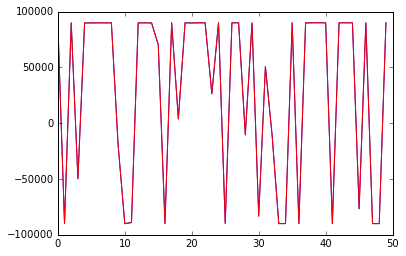

In [125]:
plt.plot(testout[0], 'b', testout[19], 'r')
plt.show()

In [124]:
(testout[0]-testout[1])*89989

array([  0.00000000e+00,   0.00000000e+00,  -5.36376238e-03,
         2.78915644e-01,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -1.44821584e-01,   0.00000000e+00,   2.14550495e-02,
         0.00000000e+00,   0.00000000e+00,  -5.36376238e-03,
        -1.14784515e+00,  -1.07275248e-02,   0.00000000e+00,
         6.20185025e-02,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,  -3.78145248e-01,
         0.00000000e+00,  -1.07275248e-02,   5.36376238e-03,
         0.00000000e+00,   6.70470297e-04,  -5.36376238e-03,
        -4.82738614e-02,   1.62522000e+00,  -2.88302228e-02,
         0.00000000e+00,   0.00000000e+00,   5.36376238e-03,
         0.00000000e+00,   5.36376238e-03,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   5.36376238e-03,   0.00000000e+00,
        -2.46733069e-01,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,

In [ ]:
testout[1]

In [ ]:
np.argmax(predict(np.asarray(testerplus).reshape((batch_size*maxPackets, packetTimeSteps, 1, dimIn)))[:2], axis = 2)

In [ ]:
testercheck